ROAD-DATASET 

**time series prediction**



**ISHITA PARMAR**

**101903639**

**4CO25**


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import random
import math
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
dataset = pd.read_excel('DATASET(3).xlsx')

In [ ]:
dataset.head()

,Unnamed: 0,year,Para-1,Para-2,Para-3,Para-4,Para-5,Para-6,Para-7,Para-8,Para-9,Para-10,Para-11,Para-12,Para-13
0,Sec_1,1,324.0,354.5,17.0,0.0,3,117,2600,400,0.0,0.0,0.0,0,1.52
1,NaN,2,324.0,161.1,18.2,0.0,4,106,5950,1190,0.0,3.4,0.0,0,1.62
2,NaN,3,324.0,170.7,18.5,0.0,4,110,5950,1190,0.0,21.3,0.0,4,1.68
3,NaN,4,324.0,223.9,18.9,0.0,3,110,6150,1340,0.0,21.3,0.0,5,1.78
4,NaN,5,324.0,228.2,18.4,0.0,2,113,6340,1450,0.0,23.9,0.0,7,1.80


**DATA PROCESSING**

In [ ]:
# Manually added row 10 in Section 9 as earlier only 9 rows were present

In [ ]:
cl_lst = []
index = 910
for i in range(9):
  cl_lst.append(index+i)
cl_lst
dataset.fillna(0, inplace=True)
dataset.drop(cl_lst, inplace = True)

In [ ]:
dataset.columns = dataset.columns.str.replace('Unnamed: 0', 'Sections')

In [ ]:
dataset.fillna(0, inplace=True)

In [ ]:
# Naming sections 
req_row = 10
j = 0
for i in range(100):
  sec_name = dataset.iloc[j,0]
  dataset.iloc[j:j + req_row, 0] = sec_name
  j += req_row
test_frame = dataset.loc[dataset['year'] == 10]
dataset.head()

,Sections,year,Para-1,Para-2,Para-3,Para-4,Para-5,Para-6,Para-7,Para-8,Para-9,Para-10,Para-11,Para-12,Para-13
0,Sec_1,1,324.0,354.5,17.0,0.0,3,117,2600,400,0.0,0.0,0.0,0,1.52
1,Sec_1,2,324.0,161.1,18.2,0.0,4,106,5950,1190,0.0,3.4,0.0,0,1.62
2,Sec_1,3,324.0,170.7,18.5,0.0,4,110,5950,1190,0.0,21.3,0.0,4,1.68
3,Sec_1,4,324.0,223.9,18.9,0.0,3,110,6150,1340,0.0,21.3,0.0,5,1.78
4,Sec_1,5,324.0,228.2,18.4,0.0,2,113,6340,1450,0.0,23.9,0.0,7,1.80


# TRAINING AND TESTING

**Defining the Light Gradient Boosting Machine**

In [ ]:
from lightgbm import LGBMRegressor
model = LGBMRegressor(random_state=19)

Extract the test and training dataset for each **section**

In [ ]:
move = 9
def extract_xtrain(df, row_start, col_start):
  row_end = row_start + move
  return df.iloc[row_start:row_end, 1:10]

In [ ]:
# Extract the training part of output dataset
def extract_ytrain(df, row_start, col_start):
  row_end = row_start + move
  return df.iloc[row_start:row_end, col_start]

In [ ]:
# Extract the testing part of input dataset
def extract_xtest(df, row_start):
  row_end = row_start + move
  return df.iloc[row_end, 1:10].to_numpy()

In [ ]:
# Extract the output part of ouput dataset
def extract_ytest(df, row_start, col_start):
  row_end = row_start + move
  return df.iloc[row_end, col_start]

In [ ]:
# function to calcuate mean square error
def calcuate_lmse(predict_val, test_val):
  pred_diff = predict_val - test_val
  return (pred_diff)**2

In [ ]:
# Get the XY Split
column_name = ["Para-"+str(i) for i in range(9,14)]
XY = []
def getXYsplit(df, row_start, row_end):
  XY = []
  XY.append(extract_xtrain(df, row_start, row_end))
  XY.append(extract_ytrain(df, row_start, row_end))
  XY.append(extract_xtest(df,row_start))
  XY.append(extract_ytest(df,row_start,row_end))
  return XY

In [ ]:
from collections import defaultdict

In [ ]:
# Create a dictionary for storing predicted and true values
pred_values = defaultdict(lambda : [])

In [ ]:
from sklearn.metrics import mean_squared_error

In [ ]:
target_col = [10,11,12,13,14]
root_mean_square_error = []
total_count = 0
curr_section = 0
total_squared_error = 0
max_val = 1000
for j in target_col:
  local_squared_error = 0
  l_count = 0
  LXY = [0,0,0,0]
  for i in range(0, max_val, 10):
    LXY = getXYsplit(dataset,i,j)
    x_train, y_train,x_test,y_test = LXY[0],LXY[1],LXY[2],LXY[3]

    # fit the model and predict
    model.fit(x_train, y_train)
    ypred = model.predict(x_test.reshape(1,-1))[0]

    # store the predicted values
    pred_values[column_name[curr_section]].append(ypred)
    
    # store squared difference for RMSE

    # local_squared_error = calcuate_lmse(ypred, y_test) + local_squared_error
    total_squared_error = calcuate_lmse(ypred, y_test) + total_squared_error
    l_count += 1
    total_count += 1

  # root_mean_square_error.append(local_squared_error)
  curr_section += 1
predicted_df = pd.DataFrame.from_dict(pred_values)

In [ ]:
# Calculate  RMSE
total_rmse_by_n = total_squared_error/total_count
final_rmse = total_rmse_by_n**0.5

print("The RMSE is " + str(final_rmse))

The RMSE is 67.78317036916836


# **PLOT**

In [ ]:
# Get random rows for plotting
plot_row = 30

random_rows = []
for i in range(plot_row):
  random_rows.append(random.randint(0,90))

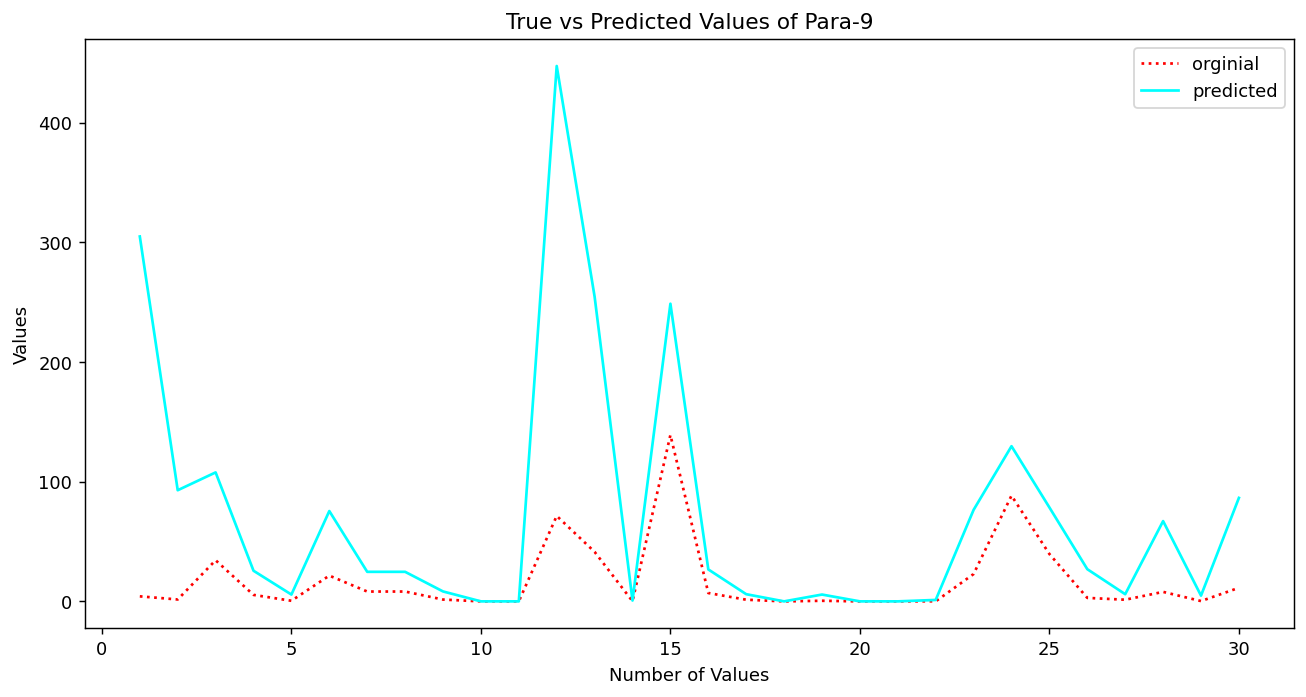

In [ ]:
figure(figsize=(12, 6), dpi=130)
true_value = predicted_df.iloc[random_rows, 0]
predicted_value = test_frame.iloc[random_rows,10]
x_value = []
for i in range(len(true_value)):
  x_value.append(i+1)
plt.plot(x_value,true_value, linestyle = 'dotted',color = 'red', label = 'orginial')
plt.plot(x_value,predicted_value, linestyle = 'solid',color = 'cyan', label = 'predicted')
plt.xlabel('Number of Values')
plt.ylabel('Values')
plt.title('True vs Predicted Values of Para-9')
plt.legend(loc = 'upper right')

# **PLOT**

In [ ]:
# Get random rows for plotting
plot_row = 30

random_rows = []
for i in range(plot_row):
  random_rows.append(random.randint(0,90))

PARA-9

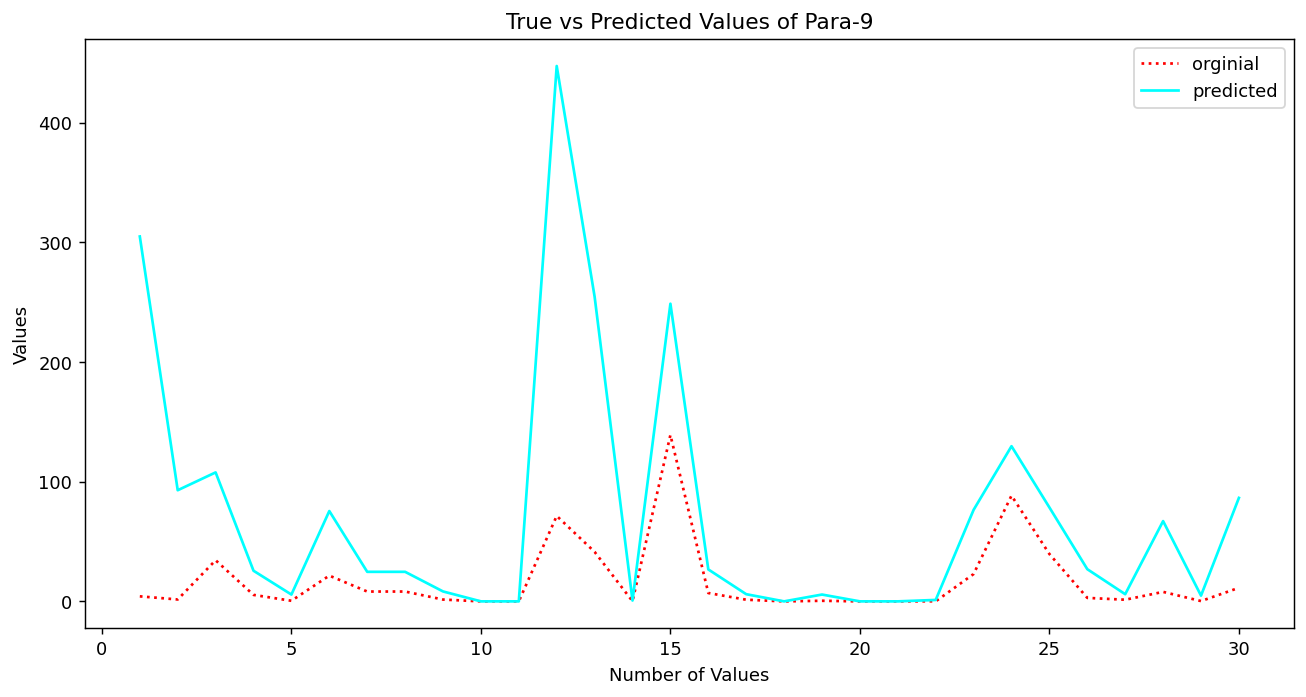

In [ ]:
figure(figsize=(12, 6), dpi=130)
true_value = predicted_df.iloc[random_rows, 0]
predicted_value = test_frame.iloc[random_rows,10]
x_value = []
for i in range(len(true_value)):
  x_value.append(i+1)
plt.plot(x_value,true_value, linestyle = 'dotted', color = 'red',  label = 'orginial')
plt.plot(x_value,predicted_value, linestyle = 'solid', color = 'cyan', label = 'predicted')

plt.xlabel('Number of Values')
plt.ylabel('Values')
plt.title('True vs Predicted Values of Para-9')
plt.legend(loc = 'upper right')

PLOT-10

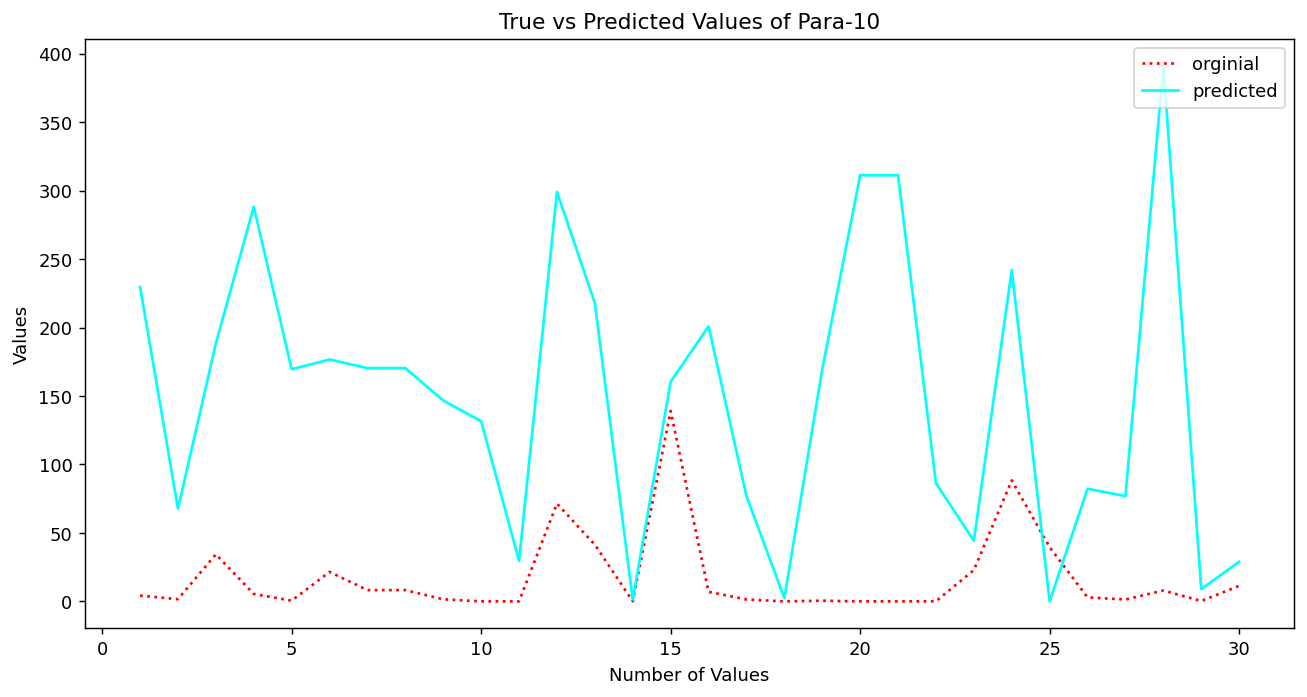

In [ ]:
figure(figsize=(12, 6), dpi=130)
true_value = predicted_df.iloc[random_rows, 0]
predicted_value = test_frame.iloc[random_rows,11]
x_value = []
for i in range(len(true_value)):
  x_value.append(i+1)
plt.plot(x_value,true_value, linestyle = 'dotted',color = 'red', label = 'orginial')
plt.plot(x_value,predicted_value, linestyle = 'solid',color = 'cyan', label = 'predicted')
plt.xlabel('Number of Values')
plt.ylabel('Values')
plt.title('True vs Predicted Values of Para-10')
plt.legend(loc = 'upper right')

PLOT-11

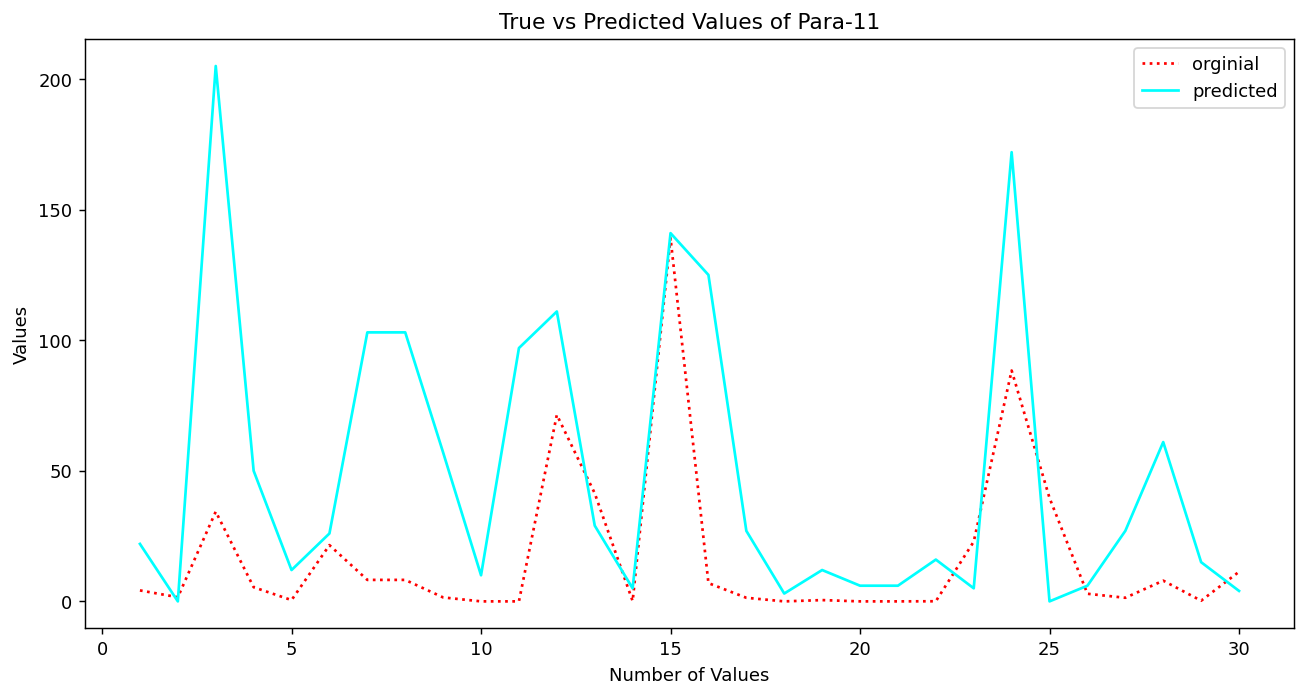

In [ ]:
figure(figsize=(12, 6), dpi=130)
true_value = predicted_df.iloc[random_rows, 0]
predicted_value = test_frame.iloc[random_rows,12]
x_value = []
for i in range(len(true_value)):
  x_value.append(i+1)
plt.plot(x_value,true_value, linestyle = 'dotted',color = 'red', label = 'orginial')
plt.plot(x_value,predicted_value, linestyle = 'solid',color = 'cyan', label = 'predicted')
plt.xlabel('Number of Values')
plt.ylabel('Values')
plt.title('True vs Predicted Values of Para-11')
plt.legend(loc = 'upper right')

PLOT-12

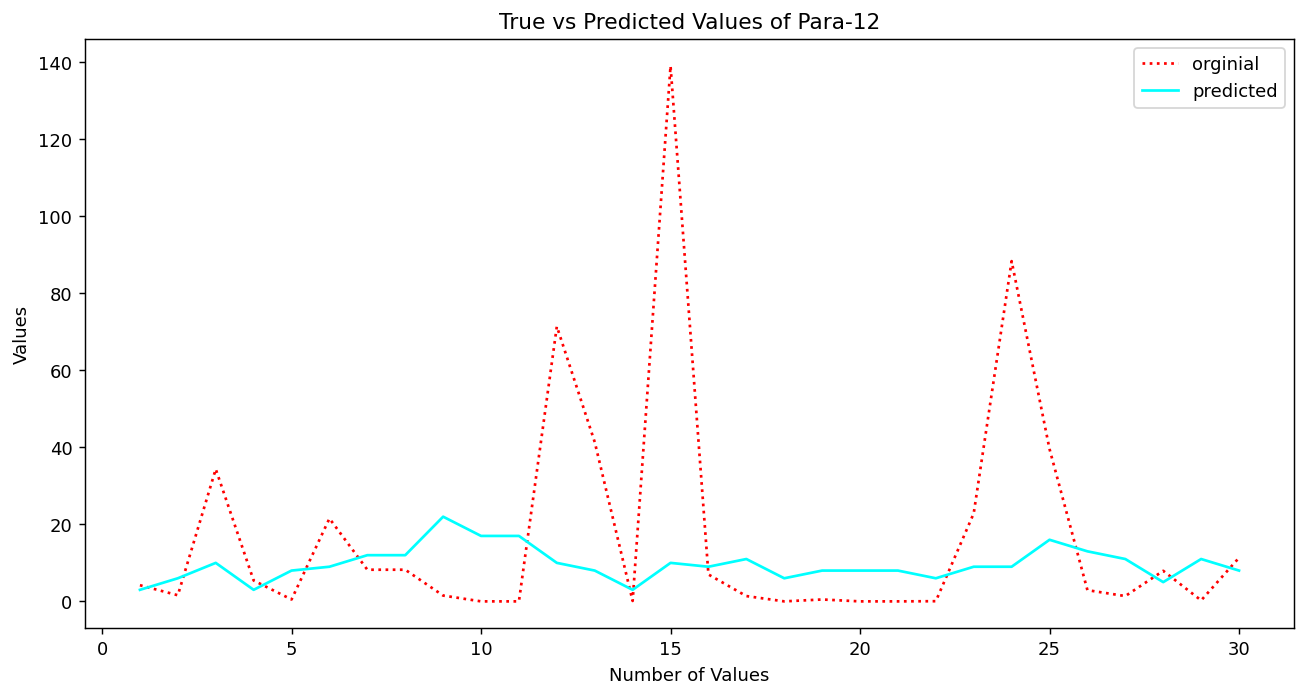

In [ ]:
figure(figsize=(12, 6), dpi=130)
true_value = predicted_df.iloc[random_rows, 0]
predicted_value = test_frame.iloc[random_rows,13]
x_value = []
for i in range(len(true_value)):
  x_value.append(i+1)
plt.plot(x_value,true_value, linestyle = 'dotted',color = 'red', label = 'orginial')
plt.plot(x_value,predicted_value, linestyle = 'solid',color = 'cyan', label = 'predicted')
plt.xlabel('Number of Values')
plt.ylabel('Values')
plt.title('True vs Predicted Values of Para-12')
plt.legend(loc = 'upper right')

PLOT-13

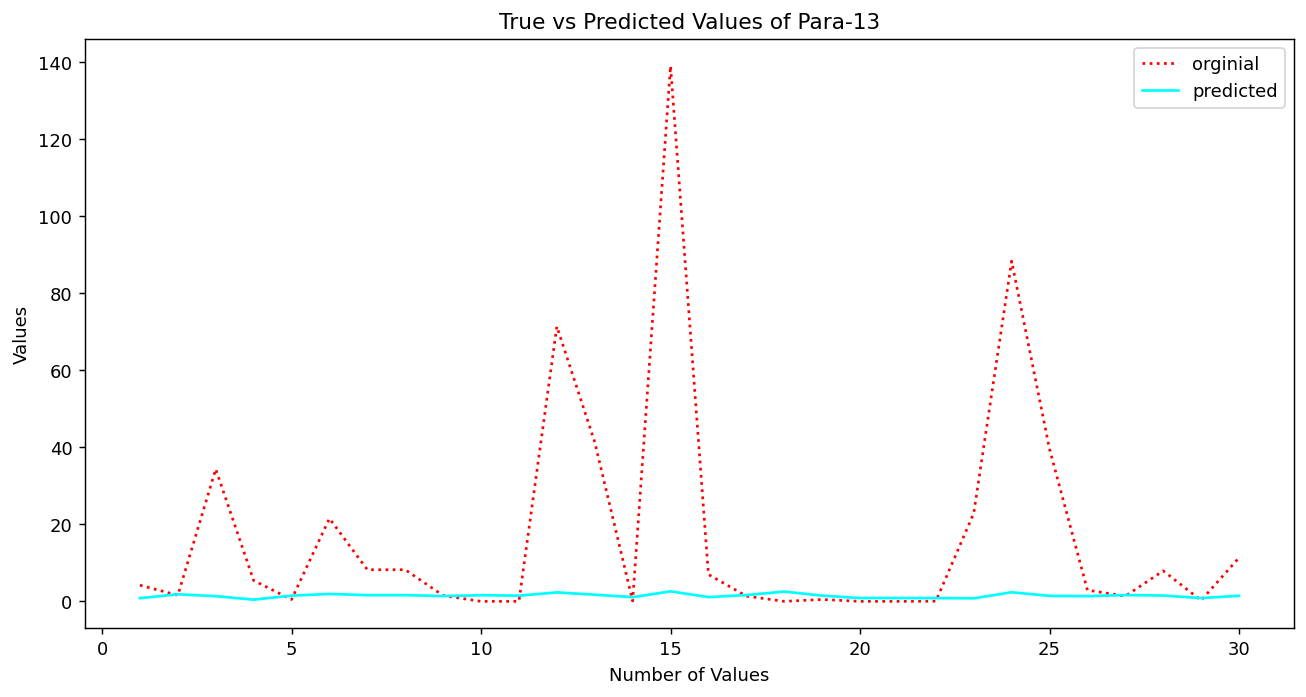

In [ ]:
figure(figsize=(12, 6), dpi=130)
true_value = predicted_df.iloc[random_rows, 0]
predicted_value = test_frame.iloc[random_rows,14]
x_value = []
for i in range(len(true_value)):
  x_value.append(i+1)
plt.plot(x_value,true_value, linestyle = 'dotted',color = 'red', label = 'orginial')
plt.plot(x_value,predicted_value, linestyle = 'solid',color = 'cyan', label = 'predicted')
plt.xlabel('Number of Values')
plt.ylabel('Values')
plt.title('True vs Predicted Values of Para-13')
plt.legend(loc = 'upper right')